In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_x = x_train / 255
val_x = x_test / 255

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   36928       ['max_pooling2d[0][0]']          
                                                                                            

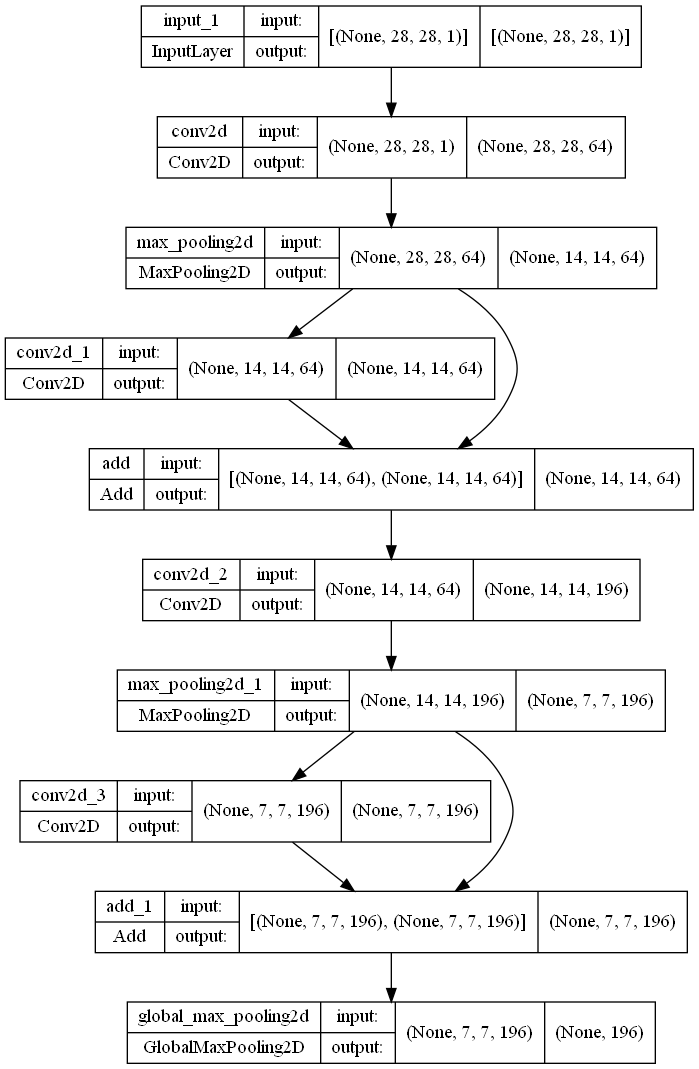

In [4]:
#Encoder
encoder_input = keras.Input(shape=(28, 28, 1))

#1st Block
x = layers.Conv2D(filters =64, kernel_size =3, padding ='same', activation='relu')(encoder_input)
Block1 = layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

#2nd Block
x = layers.Conv2D(filters =64, kernel_size =3, padding ='same', activation='relu')(Block1)
Block2 = layers.add([x, Block1])

#3rd Block
x = layers.Conv2D(filters =196, kernel_size =3, padding ='same', activation='relu')(Block2)
Block3 = layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

#4th Block
x = layers.Conv2D(filters =196, kernel_size =3, padding ='same', activation='relu')(Block3)
Block4 = layers.add([x, Block3])

encoder_output = layers.GlobalMaxPooling2D()(Block4)
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()
keras.utils.plot_model(encoder, "Encoder.png", show_shapes=True)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 196)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 14, 14, 1)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 14, 14, 64)  640         ['reshape[0][0]']                
 ose)                                                                                             
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 28, 28, 64)   0           ['conv2d_transpose[0][0]'] 

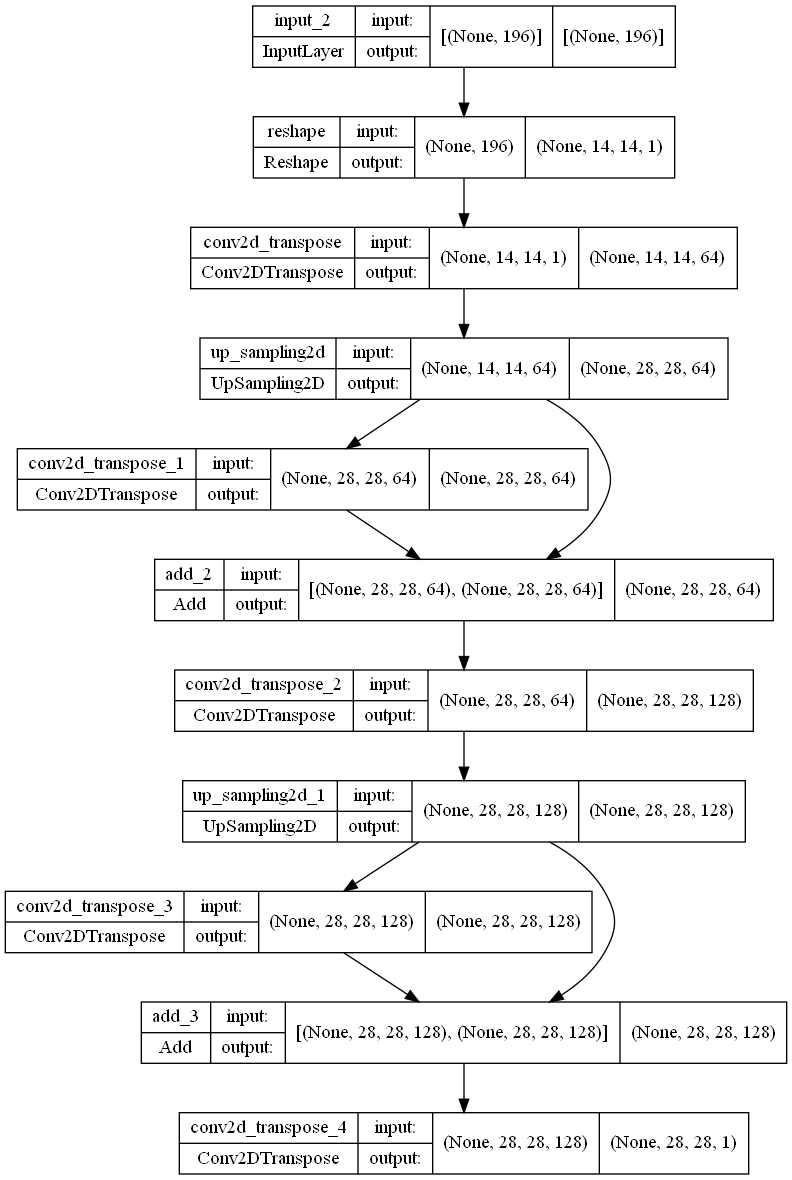

In [5]:
#Decoder
decoder_input = keras.Input(shape=(196,))
x = layers.Reshape((14,14,1))(decoder_input)

#5th Block
x = layers.Conv2DTranspose(filters =64, kernel_size =3, padding ='same', activation='relu')(x)
Block5 = layers.UpSampling2D(2)(x)

#6th Block
x = layers.Conv2DTranspose(filters =64, kernel_size =3, padding ='same', activation='relu')(Block5)
Block6 = layers.add([x, Block5])

#7th Block
x = layers.Conv2DTranspose(filters =128, kernel_size =3, padding ='same', activation='relu')(Block6)
Block7 = layers.UpSampling2D(1)(x)

#8th Block
x = layers.Conv2DTranspose(filters =128, kernel_size =3, padding ='same', activation='relu')(Block7)
Block8 = layers.add([x, Block7])

decoder_output = layers.Conv2DTranspose(filters =1, kernel_size =3, padding ='same', activation='relu')(Block8)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()
keras.utils.plot_model(decoder, "Decoder.png", show_shapes=True)

In [6]:
autoencoder_input = keras.Input(shape=(28, 28, 1))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 196)               496600    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         260161    
                                                                 
Total params: 756,761
Trainable params: 756,761
Non-trainable params: 0
_________________________________________________________________


In [43]:
checkpoint_path = "C:/Users/divya/Desktop/ML/AutoEncoder/AutoEncoderWeights.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

autoencoder.compile(optimizer="adam",
              loss ='mean_squared_error', 
              metrics=['accuracy'])

trained_model = autoencoder.fit(train_x, train_x, 
                                batch_size=64, epochs=5, 
                                verbose=1, validation_data=(val_x, val_x),
                                callbacks=[cp_callback])

Epoch 1/5
577/938 [=================>............] - ETA: 16s - loss: 0.0045 - accuracy: 0.8150

Text(0.5, 1.0, 'Input')

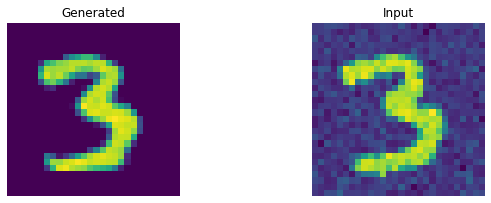

In [42]:
import matplotlib.pyplot as plt

index=500
pred_input=val_x[index]+np.random.randn(28,28)*0.07
pred=np.expand_dims(pred_input, axis=0)
output = autoencoder.predict(pred)
output = output * 255

fig = plt.figure(figsize=(10, 7))
rows=2
columns=2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(output[0])
plt.axis('off')
plt.title("Generated")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(pred_input)
plt.axis('off')
plt.title("Input")